In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
from football_sim import *
import os

In [2]:
for x in request_data('/v1/competitions/'):
    print(x['id'],x['caption'])

444 Campeonato Brasileiro da Série A
445 Premier League 2017/18
446 Championship 2017/18
447 League One 2017/18
448 League Two 2017/18
449 Eredivisie 2017/18
450 Ligue 1 2017/18
451 Ligue 2 2017/18
452 1. Bundesliga 2017/18
453 2. Bundesliga 2017/18
455 Primera Division 2017
456 Serie A 2017/18
457 Primeira Liga 2017/18
458 DFB-Pokal 2017/18
459 Serie B 2017/18
464 Champions League 2017/18
466 Australian A-League


In [33]:
LaLigaData=CompetitionResults(455)
PremierLeagueData=CompetitionResults(445)

file exists, loading


In [34]:
PremierLeagueData.update_fixtures()

In [35]:
all_data=dict()
all_data['ES']=LaLigaData.make_df()
all_data['EN']=PremierLeagueData.make_df()

In [36]:
calibrator=Calibrator('calibration_other_source.pkl')
for _country in all_data:
    calibrator.process_data(all_data[_country],_country)
teams=calibrator.teams

calibration_other_source.pkl  exists.
file exists, loading
669
('2018-04-22', 'West Bromwich Albion FC', 'Liverpool FC', 2, 2)


In [37]:
Teams=dict()
League=dict()

In [58]:
country='EN'
home_advantage=np.array(calibrator.teams['Home'+country].means())-np.array(calibrator.teams['Away'+country].means())
print(home_advantage)
Teams[country]={x:teams[x] for x in teams if teams[x].country==country}
League[country]=Season(Teams[country],home_advantage=home_advantage)
League[country].process_current_results(all_data[_country])
League[country].simulate_season(n_scenarios=100000)
League[country].season_report()

[ 0.17954514 -0.17929655]
simulation not yet processed, processing


,Points (mean),Points (low),Points (high),Place (low),Place (high),Win,CL,Off,Deff,Degr
Manchester City FC,100.4,97,102,1,1,100.0,100.00,2.33,0.14,0.00
Manchester United FC,82.6,78,86,3,2,0.0,100.00,1.38,0.13,0.00
Liverpool FC,77.8,75,80,4,2,0.0,99.27,1.73,0.18,0.00
Tottenham Hotspur FC,77.1,73,80,4,3,0.0,98.44,1.42,0.14,0.00
Chelsea FC,70.3,66,75,5,5,0.0,2.30,1.17,0.24,0.00
Arsenal FC,62.4,58,67,7,6,0.0,0.00,1.32,0.54,0.00
Burnley FC,58.6,55,62,7,6,0.0,0.00,0.50,0.16,0.00
Leicester City FC,49.5,45,54,10,8,0.0,0.00,0.92,0.52,0.00
Everton FC,47.7,43,52,11,8,0.0,0.00,0.61,0.73,0.00
Newcastle United FC,47.0,43,51,11,8,0.0,0.00,0.58,0.46,0.00


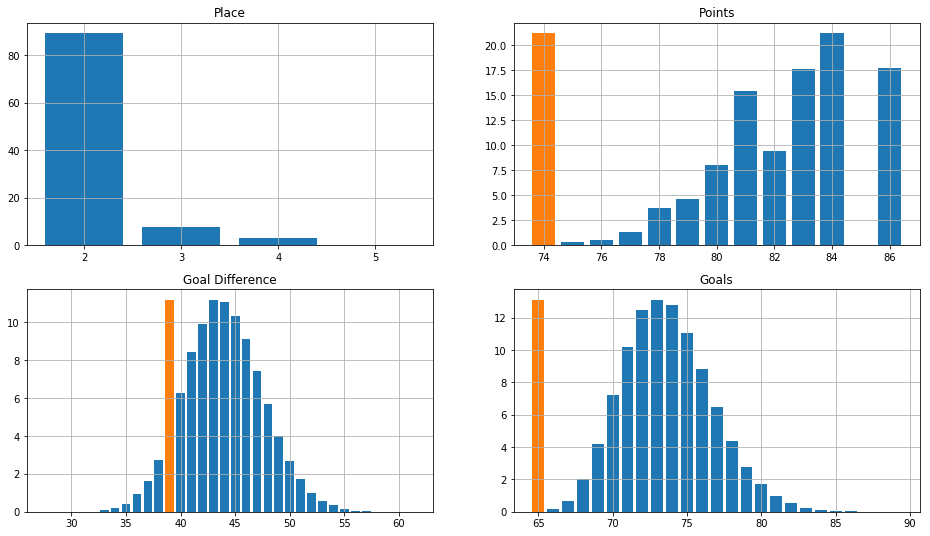

In [59]:
PremierLeague=League['EN']
PremierLeague.team_report('Manchester United FC')

array([ 99.996     , 100.        ,  99.95698462, 100.        ])

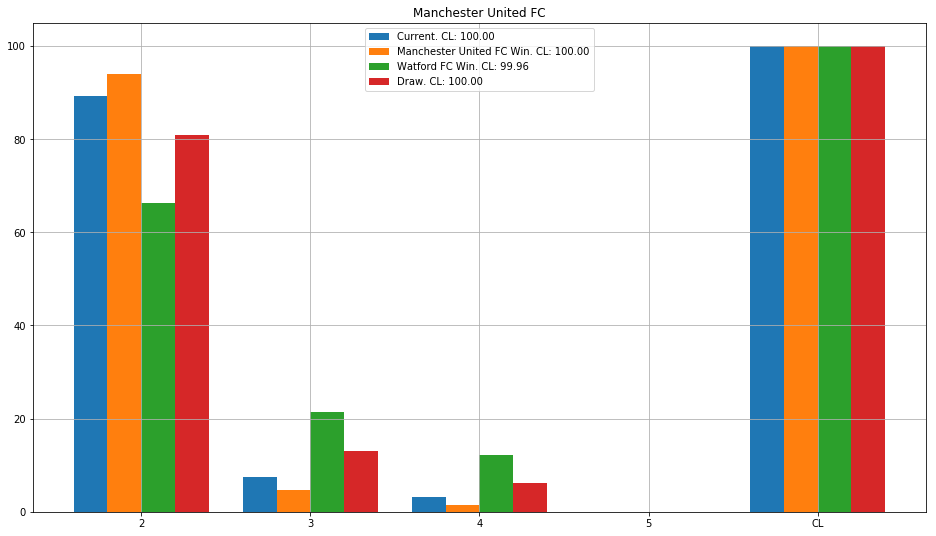

In [60]:
imp=[]
ref_team='Manchester United FC'
#ref_team='Liverpool'
#ref_team='Arsenal'
matches=[]
for x in PremierLeague.matches_to_sim:
    matches.append(x)
    pcl=PremierLeague.what_if(x,ref_team=ref_team,show_plot=False,place=2,or_better=True)
    #imp.append(pcl.max()/pcl.min())
    imp.append(pcl.std())
    #imp.append(1/pcl.min())
imp=np.array(imp)
matches=np.array(matches)
the_match=matches[imp.argmax()]
PremierLeague.what_if(the_match,ref_team=ref_team)

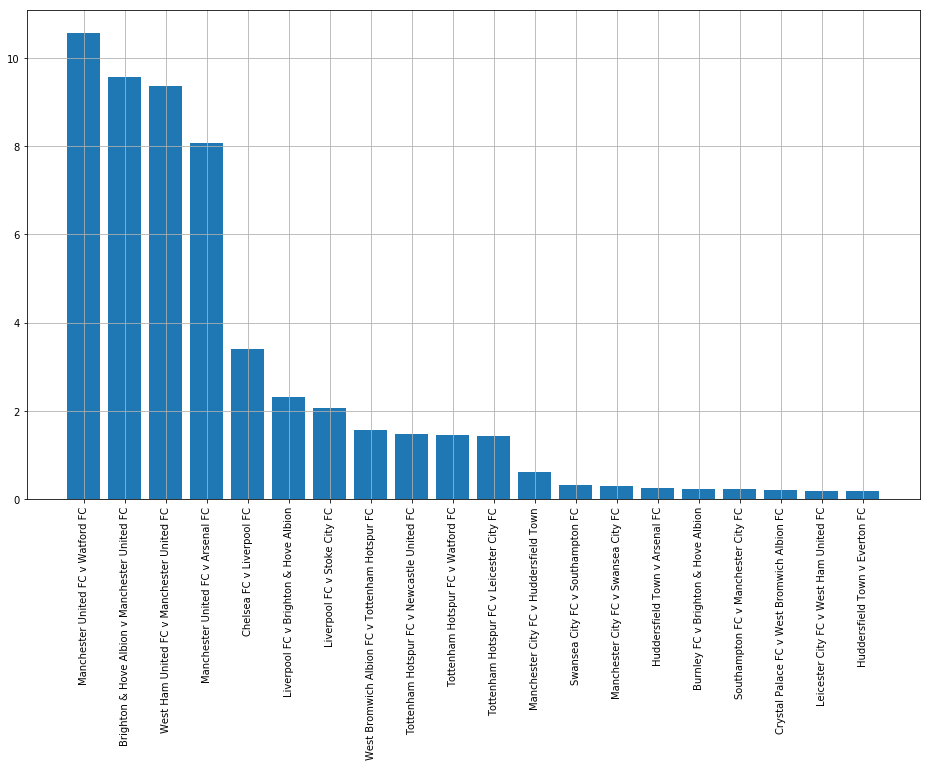

In [61]:
i_sort=(-imp).argsort()
matches=matches[i_sort]
imp=imp[i_sort]
xx=np.arange(20)
plt.bar(xx,imp[xx])
plt.xticks(xx,matches[xx],rotation=90);
plt.grid(True)
fig = plt.gcf()
fig.set_size_inches(16,9)

2.14726


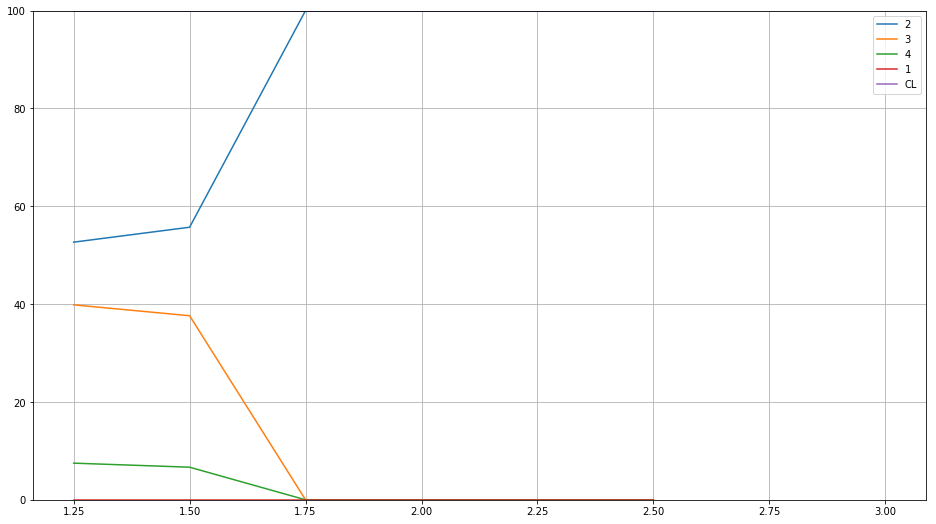

In [62]:
team_name='Manchester United FC'
#team_name='Tottenham'
#team_name='Chelsea'
#team_name='Liverpool'
i=PremierLeague.team_id[team_name]
ind=PremierLeague.place_per_team[i,:]<=4
tmp=[PremierLeague.matches_to_sim[x] for x in PremierLeague.matches_to_sim ]
n=len([x for x in tmp if x['Home']==team_name or x['Away']==team_name])
#pnts=PremierLeague.points_per_team[i,ind]-PremierLeague.current_points['Man United']
pnts=PremierLeague.points_per_team[i,:]-PremierLeague.current_points[team_name]
plc=PremierLeague.place_per_team[i,:]

nrpnts=np.arange(5,3*n+1)
p=np.zeros([nrpnts.shape[0],6])
p[:]=np.nan
for jj in range(nrpnts.shape[0]):
    ind=pnts==nrpnts[jj]
    if ind.any():
        p[jj,0]=(plc[ind]==2).sum()/ind.sum()
        p[jj,1]=(plc[ind]==3).sum()/ind.sum()
        p[jj,2]=(plc[ind]==4).sum()/ind.sum()
        p[jj,3]=(plc[ind]<=4).sum()/ind.sum()
        p[jj,4]=(plc[ind]==1).sum()/ind.sum()
    

plt.plot(nrpnts/n,100*p[:,0],label='2')
plt.plot(nrpnts/n,100*p[:,1],label='3')
plt.plot(nrpnts/n,100*p[:,2],label='4')
plt.plot(nrpnts/n,100*p[:,4],label='1')
plt.plot(nrpnts/n,100*p[:,3],label='CL')
plt.legend()
plt.grid(True)
plt.ylim([0,100])
#plt.xlabel([0,3])
print(pnts.mean()/n)
fig = plt.gcf()
fig.set_size_inches(16,9)